In [3]:
%%capture
!pip install wandb -qU

In [4]:
# Log in to your W&B account
import wandb
wandb.login()

True

# [ 문제 1 ] 수업 자료에서 제시하고 있는 다음 코드들을 Backend AI로 옮겨 실행하고 각 결과를 Backend AI 내에 잘 정리하여 제시하기

## _01_code/_15_lstm_and_its_application/g_crypto_currency_regression_train_lstm.py

In [5]:
import torch
from torch import nn, optim
from torch.utils.data import DataLoader
from datetime import datetime
import os
import wandb
from pathlib import Path
from easydict import EasyDict

BASE_PATH = str(Path("__file__").resolve().parent.parent.parent)  # BASE_PATH: /Users/yhhan/git/link_dl
import sys
sys.path.append(BASE_PATH)

CURRENT_FILE_PATH = os.path.dirname(os.path.abspath("__file__"))
CHECKPOINT_FILE_PATH = os.path.join(CURRENT_FILE_PATH, "checkpoints")

if not os.path.isdir(CHECKPOINT_FILE_PATH):
    os.makedirs(os.path.join(CURRENT_FILE_PATH, "checkpoints"))

from _01_code._14_rnn.g_rnn_trainer import RegressionTrainer
from _01_code._03_real_world_data_to_tensors.p_cryptocurrency_dataset_dataloader import get_cryptocurrency_data, \
    CryptoCurrencyDataset

def get_config():
    return EasyDict({
        "wandb": True,
        "batch_size": 2048,
        "epochs": 10000,
        "learning_rate": 0.0001,
        "weight_decay": 0.0,
        "validation_intervals": 30,
        "early_stop_patience": 30,
        "early_stop_delta": 0.000001
    })

def get_btc_krw_data(sequence_size=21, validation_size=150, test_size=30, is_regression=True):
    X_train, X_validation, X_test, y_train, y_validation, y_test, y_train_date, y_validation_date, y_test_date \
        = get_cryptocurrency_data(
            sequence_size=sequence_size, validation_size=validation_size, test_size=test_size,
            target_column='Close', y_normalizer=1.0e7, is_regression=is_regression
        )

    train_crypto_currency_dataset = CryptoCurrencyDataset(X=X_train, y=y_train)
    validation_crypto_currency_dataset = CryptoCurrencyDataset(X=X_validation, y=y_validation)
    test_crypto_currency_dataset = CryptoCurrencyDataset(X=X_test, y=y_test)

    train_data_loader = DataLoader(
        dataset=train_crypto_currency_dataset, batch_size=wandb.config.batch_size, shuffle=True
    )
    validation_data_loader = DataLoader(
        dataset=validation_crypto_currency_dataset, batch_size=wandb.config.batch_size, shuffle=True
    )
    test_data_loader = DataLoader(
        dataset=test_crypto_currency_dataset, batch_size=len(test_crypto_currency_dataset), shuffle=True
    )

    return train_data_loader, validation_data_loader, test_data_loader

def get_model():
    class MyModel(nn.Module):
        def __init__(self, n_input, n_output):
            super().__init__()
            self.lstm = nn.LSTM(input_size=n_input, hidden_size=128, num_layers=2, batch_first=True)
            self.fcn = nn.Linear(in_features=128, out_features=n_output)

        def forward(self, x):
            x, hidden = self.lstm(x)
            x = x[:, -1, :]  # x.shape: [32, 128]
            x = self.fcn(x)
            return x

    return MyModel(n_input=5, n_output=1)

def main(config):
    run_time_str = datetime.now().astimezone().strftime('%Y-%m-%d_%H-%M-%S')
    project_name = "lstm_regression_btc_krw"
    wandb.init(
        mode="online" if config.wandb else "disabled",
        project=project_name,
        notes="btc_krw experiment with lstm",
        tags=["lstm", "regression", "btc_krw"],
        name=run_time_str,
        config=config
    )

    train_data_loader, validation_data_loader, _ = get_btc_krw_data()
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print(f"Training on device {device}.")

    model = get_model()
    model.to(device)

    optimizer = optim.Adam(model.parameters(), lr=config.learning_rate, weight_decay=config.weight_decay)
    regression_trainer = RegressionTrainer(
        project_name, model, optimizer, train_data_loader, validation_data_loader, None,
        run_time_str, wandb, device, CHECKPOINT_FILE_PATH
    )
    regression_trainer.train_loop()
    wandb.finish()

if __name__ == "__main__":
    config = get_config()
    main(config)


/usr/local/lib/python3.10/dist-packages/pydantic/main.py:314: UserWarning: Pydantic serializer warnings:
  Expected `list[str]` but got `tuple` - serialized value may not be as expected
  return self.__pydantic_serializer__.to_python(


Training on device cuda:0.
[Epoch   1] T_loss: 6.19989, V_loss: 13.51782, Early stopping is stated! | T_time: 00:00:00, T_speed: 0.005
[Epoch  30] T_loss: 2.96197, V_loss: 6.44334, V_loss decreased (13.51782 --> 6.44334). Saving model... | T_time: 00:00:01, T_speed: 0.075
[Epoch  60] T_loss: 0.27746, V_loss: 0.05926, V_loss decreased (6.44334 --> 0.05926). Saving model... | T_time: 00:00:02, T_speed: 0.092
[Epoch  90] T_loss: 0.11513, V_loss: 0.03337, V_loss decreased (0.05926 --> 0.03337). Saving model... | T_time: 00:00:03, T_speed: 0.125
[Epoch 120] T_loss: 0.08398, V_loss: 0.02895, V_loss decreased (0.03337 --> 0.02895). Saving model... | T_time: 00:00:04, T_speed: 0.153
[Epoch 150] T_loss: 0.06773, V_loss: 0.02472, V_loss decreased (0.02895 --> 0.02472). Saving model... | T_time: 00:00:05, T_speed: 0.174
[Epoch 180] T_loss: 0.05612, V_loss: 0.02558, Early stopping counter: 1 out of 30 | T_time: 00:00:07, T_speed: 1.559
[Epoch 210] T_loss: 0.04758, V_loss: 0.02899, Early stopping c

[Epoch 1980] T_loss: 0.00972, V_loss: 0.00773, Early stopping counter: 12 out of 30 | T_time: 00:01:27, T_speed: 5.738
[Epoch 2010] T_loss: 0.01005, V_loss: 0.00859, Early stopping counter: 13 out of 30 | T_time: 00:01:28, T_speed: 2.632
[Epoch 2040] T_loss: 0.00955, V_loss: 0.00899, Early stopping counter: 14 out of 30 | T_time: 00:01:30, T_speed: 436.270
[Epoch 2070] T_loss: 0.00935, V_loss: 0.00701, V_loss decreased (0.00771 --> 0.00701). Saving model... | T_time: 00:01:31, T_speed: 4.538
[Epoch 2100] T_loss: 0.00919, V_loss: 0.00766, Early stopping counter: 1 out of 30 | T_time: 00:01:32, T_speed: 2.369
[Epoch 2130] T_loss: 0.00927, V_loss: 0.00948, Early stopping counter: 2 out of 30 | T_time: 00:01:34, T_speed: 7.487
[Epoch 2160] T_loss: 0.00917, V_loss: 0.01078, Early stopping counter: 3 out of 30 | T_time: 00:01:35, T_speed: 3.879
[Epoch 2190] T_loss: 0.00898, V_loss: 0.01091, Early stopping counter: 4 out of 30 | T_time: 00:01:36, T_speed: 2.246
[Epoch 2220] T_loss: 0.00859, V

Epoch,▁▁▁▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇████
Training loss,█▄▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Training speed (epochs/sec.),▁▁▁▁▁▁▁▂▂▁▂▁▂▁▁▁▇▂▂▂▃▂▃▂▂▂▂█▅▂▄▂▃▂▂▃▂▅▄▇
Validation loss,█▄▄▄▄▂▂▂▂▂▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▂▁▂▁▁▂▁▂
Epoch,3510
Training loss,0.00565
Training speed (epochs/sec.),24.84129
Validation loss,0.011


## _01_code/_15_lstm_and_its_application/h_crypto_currency_regression_test_lstm.py

MODEL FILE: /home/work/homework/link_dl/_02_homeworks/homework_3/checkpoints/lstm_regression_btc_krw_checkpoint_latest.pt
[TEST DATA]
 0: 481.03 <--> 464.58 (Loss:         16.46)
 1: 464.78 <--> 466.85 (Loss:          2.07)
 2: 441.89 <--> 455.68 (Loss:         13.79)
 3: 477.39 <--> 468.41 (Loss:          8.98)
 4: 407.48 <--> 444.08 (Loss:         36.60)
 5: 399.03 <--> 404.00 (Loss:          4.97)
 6: 404.65 <--> 405.02 (Loss:          0.37)
 7: 475.69 <--> 462.33 (Loss:         13.36)
 8: 483.02 <--> 461.57 (Loss:         21.44)
 9: 482.79 <--> 459.89 (Loss:         22.90)


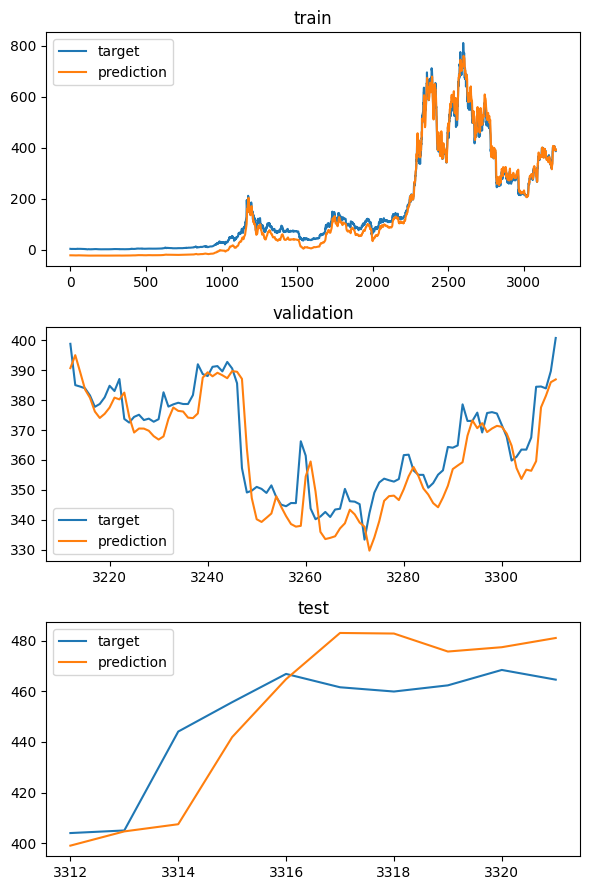

In [9]:
import torch
import wandb
from matplotlib import pyplot as plt
from datetime import datetime
import os
from pathlib import Path
from easydict import EasyDict

BASE_PATH = str(Path("__file__").resolve().parent.parent.parent)  # BASE_PATH: /Users/yhhan/git/link_dl
import sys
sys.path.append(BASE_PATH)

CURRENT_FILE_PATH = os.path.dirname(os.path.abspath("__file__"))
CHECKPOINT_FILE_PATH = os.path.join(CURRENT_FILE_PATH, "checkpoints")
if not os.path.isdir(CHECKPOINT_FILE_PATH):
    os.makedirs(os.path.join(CURRENT_FILE_PATH, "checkpoints"))

from _01_code._15_lstm_and_its_application.g_crypto_currency_regression_train_lstm import get_model, get_btc_krw_data
from _01_code._03_real_world_data_to_tensors.p_cryptocurrency_dataset_dataloader import CryptoCurrencyDataset, get_cryptocurrency_data

def get_config():
    return EasyDict({
        "wandb": True,
        "batch_size": 2048,
        "epochs": 10000,
        "learning_rate": 0.0001,
        "weight_decay": 0.0,
        "validation_intervals": 30,
        "early_stop_patience": 30,
        "early_stop_delta": 0.000001,
    })

def test(test_model):
    _, _, test_data_loader = get_btc_krw_data()

    test_model.eval()
    y_normalizer = 100

    print("[TEST DATA]")
    with torch.no_grad():
        for test_batch in test_data_loader:
            input_test, target_test = test_batch
            output_test = test_model(input_test)

        for idx, (output, target) in enumerate(zip(output_test, target_test)):
            print("{0:2}: {1:6,.2f} <--> {2:6,.2f} (Loss: {3:>13,.2f})".format(
                idx,
                output.item() * y_normalizer,
                target.item() * y_normalizer,
                abs(output.squeeze(dim=-1).item() - target.item()) * y_normalizer
            ))

def predict_all(test_model):
    y_normalizer = 100

    X_train, X_validation, X_test, y_train, y_validation, y_test, y_train_date, y_validation_date, y_test_date \
        = get_cryptocurrency_data(
            sequence_size=10, validation_size=100, test_size=10,
            target_column='Close', y_normalizer=1.0e7, is_regression=True
        )

    train_crypto_currency_dataset = CryptoCurrencyDataset(X=X_train, y=y_train)
    validation_crypto_currency_dataset = CryptoCurrencyDataset(X=X_validation, y=y_validation)
    test_crypto_currency_dataset = CryptoCurrencyDataset(X=X_test, y=y_test)

    dataset_list = [train_crypto_currency_dataset, validation_crypto_currency_dataset, test_crypto_currency_dataset]
    dataset_labels = ["train", "validation", "test"]
    num = 0
    fig, axs = plt.subplots(3, 1, figsize=(6, 9))

    for i in range(3):
        X = []
        TARGET_Y = []
        PREDICTION_Y = []
        for data in dataset_list[i]:
            input, target = data
            prediction = test_model(input.unsqueeze(0)).squeeze(-1).squeeze(-1)

            X.append(num)
            TARGET_Y.append(target.item() * y_normalizer)
            PREDICTION_Y.append(prediction.item() * y_normalizer)

            num += 1

        axs[i].plot(X, TARGET_Y, label='target')
        axs[i].plot(X, PREDICTION_Y, label='prediction')
        axs[i].set_title(dataset_labels[i])
        axs[i].legend()

    plt.tight_layout()
    plt.show()

def main(config):
    run_time_str = datetime.now().astimezone().strftime('%Y-%m-%d_%H-%M-%S')
    project_name = "lstm_regression_btc_krw"
    wandb.init(
        mode="online",
        project=project_name,
        notes="btc_krw experiment with lstm",
        tags=["lstm", "regression", "btc_krw"],
        name=run_time_str,
        config=config
    )

    test_model = get_model()
    latest_file_path = os.path.join(CHECKPOINT_FILE_PATH, f"{project_name}_checkpoint_latest.pt")
    print("MODEL FILE: {0}".format(latest_file_path))
    test_model.load_state_dict(torch.load(latest_file_path, map_location=torch.device('cpu')))

    test(test_model)
    predict_all(test_model)

if __name__ == "__main__":
    config = get_config()
    main(config)


## _01_code/_15_lstm_and_its_application/i_crypto_currency_classification_train_lstm.py

In [48]:
import torch
from torch import nn, optim
from datetime import datetime
import os
import wandb
from pathlib import Path
from easydict import EasyDict

BASE_PATH = str(Path("__file__").resolve().parent.parent.parent)  # BASE_PATH: /Users/yhhan/git/link_dl
import sys
sys.path.append(BASE_PATH)

CURRENT_FILE_PATH = os.path.dirname(os.path.abspath("__file__"))
CHECKPOINT_FILE_PATH = os.path.join(CURRENT_FILE_PATH, "checkpoints")

if not os.path.isdir(CHECKPOINT_FILE_PATH):
    os.makedirs(os.path.join(CURRENT_FILE_PATH, "checkpoints"))

from _01_code._08_fcn_best_practice.c_trainer import ClassificationTrainer
from _01_code._15_lstm_and_its_application.g_crypto_currency_regression_train_lstm import get_btc_krw_data

def get_config():
    return EasyDict({
        "wandb": True,
        "batch_size": 2048,
        "epochs": 10000,
        "learning_rate": 0.0001,
        "weight_decay": 0.0,
        "validation_intervals": 30,
        "early_stop_patience": 30,
        "early_stop_delta": 0.000001,
    })


def get_model():
    class MyModel(nn.Module):
        def __init__(self, n_input, n_output):
            super().__init__()

            self.lstm = nn.LSTM(input_size=n_input, hidden_size=256, num_layers=3, batch_first=True)
            self.fcn = nn.Linear(in_features=256, out_features=n_output)

        def forward(self, x):
            x, hidden = self.lstm(x)
            x = x[:, -1, :]  # x.shape: [32, 128]
            x = self.fcn(x)
            return x

    return MyModel(n_input=5, n_output=2)

def main(config):
    run_time_str = datetime.now().astimezone().strftime('%Y-%m-%d_%H-%M-%S')

    project_name = "lstm_classification_btc_krw"
    wandb.init(
        mode="online" if config.wandb else "disabled",
        project=project_name,
        notes="btc_krw experiment with lstm",
        tags=["lstm", "classification", "btc_krw"],
        name=run_time_str,
        config=config
    )
    print(config)
    print(wandb.config)

    train_data_loader, validation_data_loader, _ = get_btc_krw_data(is_regression=False)
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print(f"Training on device {device}.")

    model = get_model()
    model.to(device)

    optimizer = optim.Adam(model.parameters(), lr=config.learning_rate, weight_decay=config.weight_decay)

    classification_trainer = ClassificationTrainer(
        project_name, model, optimizer, train_data_loader, validation_data_loader, None,
        run_time_str, wandb, device, CHECKPOINT_FILE_PATH
    )
    classification_trainer.train_loop()

    wandb.finish()

if __name__ == "__main__":
    config = get_config()
    main(config)


/usr/local/lib/python3.10/dist-packages/pydantic/main.py:314: UserWarning: Pydantic serializer warnings:
  Expected `list[str]` but got `tuple` - serialized value may not be as expected
  return self.__pydantic_serializer__.to_python(


{'wandb': True, 'batch_size': 2048, 'epochs': 10000, 'learning_rate': 0.0001, 'weight_decay': 0.0, 'validation_intervals': 30, 'early_stop_patience': 30, 'early_stop_delta': 1e-06}
{'wandb': True, 'batch_size': 2048, 'epochs': 10000, 'learning_rate': 0.0001, 'weight_decay': 0.0, 'validation_intervals': 30, 'early_stop_patience': 30, 'early_stop_delta': 1e-06}
Training on device cuda:0.
[Epoch   1] T_loss: 0.69383, T_accuracy: 47.1980 | V_loss: 0.69325, V_accuracy: 49.0000 | Early stopping is stated! | T_time: 00:00:00, T_speed: 0.000
[Epoch  30] T_loss: 0.69092, T_accuracy: 53.1445 | V_loss: 0.69263, V_accuracy: 51.0000 | V_loss decreased (0.69325 --> 0.69263). Saving model... | T_time: 00:00:01, T_speed: 30.000
[Epoch  60] T_loss: 0.68946, T_accuracy: 53.1756 | V_loss: 0.69262, V_accuracy: 51.0000 | V_loss decreased (0.69263 --> 0.69262). Saving model... | T_time: 00:00:03, T_speed: 20.000
[Epoch  90] T_loss: 0.69000, T_accuracy: 53.1445 | V_loss: 0.69258, V_accuracy: 51.0000 | V_loss

Epoch,▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇███
Training accuracy (%),▁▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇█████
Training loss,█▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▆▆▆▆▆▅▅▅▄▄▃▃▃▂▂▂▂▁▁▂
Training speed (epochs/sec.),▁█▆▆▆▅▆▅▅▆▅▆▅▅▅▅▅▅▆▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅
Validation accuracy (%),▃▅▅▅▅▅▅▅▅▅▅█▃▃▃▃▃▃▃▃▃▄▄▆▅▅▅▅▅▆▆▄▆▃▂▁▁
Validation loss,▂▁▁▁▁▁▁▁▁▁▁▂▃▅▄▅▄▃▄▂▂▂▂▁▁▁▂▂▂▃▃▃▄▅▆██
Epoch,1080
Training accuracy (%),56.00872
Training loss,0.6697
Training speed (epochs/sec.),18.94737
Validation accuracy (%),46


## _01_code/_15_lstm_and_its_application/j_crypto_currency_classification_test_lstm.py

In [49]:
import torch
import os
from pathlib import Path
from datetime import datetime
import wandb
from easydict import EasyDict

BASE_PATH = str(Path("__file__").resolve().parent.parent.parent)  # BASE_PATH: /Users/yhhan/git/link_dl
import sys
sys.path.append(BASE_PATH)

CURRENT_FILE_PATH = os.path.dirname(os.path.abspath("__file__"))
CHECKPOINT_FILE_PATH = os.path.join(CURRENT_FILE_PATH, "checkpoints")

if not os.path.isdir(CHECKPOINT_FILE_PATH):
    os.makedirs(os.path.join(CURRENT_FILE_PATH, "checkpoints"))

from _01_code._15_lstm_and_its_application.g_crypto_currency_regression_train_lstm import get_btc_krw_data
from _01_code._15_lstm_and_its_application.i_crypto_currency_classification_train_lstm import get_model

def get_config():
    return EasyDict({
        "wandb": True,
        "batch_size": 2048,
        "epochs": 10000,
        "learning_rate": 0.0001,
        "weight_decay": 0.0,
        "validation_intervals": 30,
        "early_stop_patience": 30,
        "early_stop_delta": 0.000001,
    })

def test(test_model):
    _, _, test_data_loader = get_btc_krw_data(is_regression=False)

    test_model.eval()
    num_corrects_test = 0
    num_tested_samples = 0

    print("[TEST DATA]")
    with torch.no_grad():
        for test_batch in test_data_loader:
            input_test, target_test = test_batch
            output_test = test_model(input_test)
            predicted_test = torch.argmax(output_test, dim=1)
            num_corrects_test += torch.sum(torch.eq(predicted_test, target_test))
            num_tested_samples += len(input_test)

        test_accuracy = 100.0 * num_corrects_test / num_tested_samples
        print(f"TEST RESULTS: {test_accuracy:6.3f}%")

        for idx, (output, target) in enumerate(zip(output_test, target_test)):
            print("{0:2}: {1:6,.2f} <--> {2:6,.2f}".format(
                idx, torch.argmax(output).item(), target.item()
            ))

def main(config):
    run_time_str = datetime.now().astimezone().strftime('%Y-%m-%d_%H-%M-%S')
    project_name = "lstm_classification_btc_krw"
    
    wandb.init(
        mode="online" if config.wandb else "disabled",
        project=project_name,
        notes="btc_krw experiment with lstm",
        tags=["lstm", "classification", "btc_krw"],
        name=run_time_str,
        config=config
)


    test_model = get_model()

    latest_file_path = os.path.join(
        CHECKPOINT_FILE_PATH, "lstm_classification_btc_krw_checkpoint_latest.pt"
    )
    print("MODEL FILE: {0}".format(latest_file_path))
    test_model.load_state_dict(torch.load(latest_file_path, map_location=torch.device('cpu')))

    test(test_model)

if __name__ == "__main__":
    config = get_config()
    main(config)

/usr/local/lib/python3.10/dist-packages/pydantic/main.py:314: UserWarning: Pydantic serializer warnings:
  Expected `list[str]` but got `tuple` - serialized value may not be as expected
  return self.__pydantic_serializer__.to_python(


MODEL FILE: /home/work/homework/link_dl/_02_homeworks/homework_3/checkpoints/lstm_classification_btc_krw_checkpoint_latest.pt
[TEST DATA]
TEST RESULTS: 70.000%
 0:   0.00 <-->   0.00
 1:   0.00 <-->   1.00
 2:   1.00 <-->   1.00
 3:   0.00 <-->   0.00
 4:   0.00 <-->   0.00
 5:   1.00 <-->   1.00
 6:   0.00 <-->   1.00
 7:   1.00 <-->   1.00
 8:   1.00 <-->   1.00
 9:   0.00 <-->   1.00


# [문제 2] 적절한 새로운 모델 구성 및 하이퍼파라미터 찾기

## Classificaition

In [44]:
import torch
from torch import nn, optim
from datetime import datetime
import os
import wandb
from pathlib import Path
from easydict import EasyDict

BASE_PATH = str(Path("__file__").resolve().parent.parent.parent)  # BASE_PATH: /Users/yhhan/git/link_dl
import sys
sys.path.append(BASE_PATH)

CURRENT_FILE_PATH = os.path.dirname(os.path.abspath("__file__"))
CHECKPOINT_FILE_PATH = os.path.join(CURRENT_FILE_PATH, "checkpoints")

if not os.path.isdir(CHECKPOINT_FILE_PATH):
    os.makedirs(os.path.join(CURRENT_FILE_PATH, "checkpoints"))

from _01_code._08_fcn_best_practice.c_trainer import ClassificationTrainer
from _01_code._15_lstm_and_its_application.g_crypto_currency_regression_train_lstm import get_btc_krw_data


# Config 설정
def get_config():
    return EasyDict({
        "wandb": True,
        "batch_size": 2048,
        "epochs": 10000,
        "learning_rate": 0.0001,
        "weight_decay": 0.01, 
        "validation_intervals": 30,
        "early_stop_patience": 30,
        "early_stop_delta": 0.00001,
    })


# 모델 정의
def get_model():
    class MyModel(nn.Module):
        def __init__(self, n_input, n_output):
            super().__init__()

            self.lstm = nn.LSTM(input_size=n_input, hidden_size=256, num_layers=3, batch_first=True)
            self.fcn = nn.Linear(in_features=256, out_features=n_output)

        def forward(self, x):
            x, hidden = self.lstm(x)
            x = x[:, -1, :]  # x.shape: [batch_size, hidden_size]
            x = self.fcn(x)
            return x

    return MyModel(n_input=5, n_output=2)


# Main 함수
def main(config):
    run_time_str = datetime.now().astimezone().strftime('%Y-%m-%d_%H-%M-%S')

    # wandb 초기화
    project_name = "hy_lstm_classification_btc_krw"
    wandb.init(
        mode="online",
        project=project_name,
        notes="btc_krw experiment with lstm",
        tags=["lstm", "classification", "btc_krw"],
        name=run_time_str,
        config=dict(config)  # EasyDict를 dict로 변환
    )

    # wandb config 확인
    print("wandb.config:", dict(wandb.config))

    train_data_loader, validation_data_loader, _ = get_btc_krw_data(is_regression=False)
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print(f"Training on device {device}.")

    model = get_model()
    model.to(device)

    # 옵티마이저 설정
    optimizer = optim.Adam(
        model.parameters(),
        lr=wandb.config.learning_rate,  # wandb.config에서 학습률 가져옴
        
    )

    # 학습 루프 실행
    classification_trainer = ClassificationTrainer(
        project_name, model, optimizer, train_data_loader, validation_data_loader, None,
        run_time_str, wandb, device, CHECKPOINT_FILE_PATH
    )
    classification_trainer.train_loop()

    wandb.finish()


# 실행
if __name__ == "__main__":
    config = get_config()
    main(config)


wandb.config: {'wandb': True, 'batch_size': 2048, 'epochs': 10000, 'learning_rate': 0.0001, 'weight_decay': 0.0, 'validation_intervals': 30, 'early_stop_patience': 30, 'early_stop_delta': 1e-06}
Training on device cuda:0.
[Epoch   1] T_loss: 0.69140, T_accuracy: 52.8020 | V_loss: 0.69320, V_accuracy: 51.0000 | Early stopping is stated! | T_time: 00:00:00, T_speed: 0.000
[Epoch  30] T_loss: 0.68980, T_accuracy: 53.0199 | V_loss: 0.69261, V_accuracy: 51.0000 | V_loss decreased (0.69320 --> 0.69261). Saving model... | T_time: 00:00:01, T_speed: 30.000
[Epoch  60] T_loss: 0.69115, T_accuracy: 53.0822 | V_loss: 0.69259, V_accuracy: 51.0000 | V_loss decreased (0.69261 --> 0.69259). Saving model... | T_time: 00:00:03, T_speed: 20.000
[Epoch  90] T_loss: 0.69004, T_accuracy: 53.1133 | V_loss: 0.69258, V_accuracy: 51.0000 | V_loss decreased (0.69259 --> 0.69258). Saving model... | T_time: 00:00:05, T_speed: 18.000
[Epoch 120] T_loss: 0.69024, T_accuracy: 53.1133 | V_loss: 0.69258, V_accuracy: 5

Epoch,▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▆▆▆▆▆▇▇▇▇▇███
Training accuracy (%),▁▁▂▂▂▂▂▂▂▂▃▂▂▃▂▂▃▄▃▄▄▅▄▄▄▅▆▆▆▆▆▆▇██
Training loss,███████████▇▇▇▇▇▇▇▇▇▆▆▆▆▆▅▅▄▄▃▃▃▂▁▁
Training speed (epochs/sec.),▁█▆▅▆▅▅▅▅▆▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅
Validation accuracy (%),▆▆▆▆▆▆▆▆▆▆▃▄▅▅▅▃▆▄▆▆▃▄▆▆▆▆█▅▆▆▁▁▂▁▂
Validation loss,▂▁▁▁▁▁▁▁▁▁▂▃▅▄▅▃▃▃▂▂▂▁▂▂▂▃▃▃▄▄▅▅▆██
Epoch,1020
Training accuracy (%),56.38232
Training loss,0.6671
Training speed (epochs/sec.),18.54545
Validation accuracy (%),45


In [52]:
!wandb sync /home/work/homework/link_dl/_02_homeworks/homework_3/wandb/run-20241220_062716-7hlt16tj

Find logs at: /home/work/homework/link_dl/_02_homeworks/homework_3/wandb/debug-cli.work.log
/home/work/homework/link_dl/_02_homeworks/homework_3/wandb/run-20241220_062716-7hlt16tj
/usr/local/lib/python3.10/dist-packages/pydantic/main.py:314: UserWarning: Pydantic serializer warnings:
  Expected `list[str]` but got `tuple` - serialized value may not be as expected
  return self.__pydantic_serializer__.to_python(
Syncing: https://wandb.ai/jissu02/lstm_classification_btc_krw/runs/7hlt16tj ... done.


In [53]:
cat /home/work/homework/link_dl/_02_homeworks/homework_3/wandb/run-20241220_062716-7hlt16tj/files/wandb-summary.json

{"Training loss": 0.667095273733139, "Training accuracy (%)": 56.38231631382316, "Training speed (epochs/sec.)": 18.545454545454547, "_step": 34, "_runtime": 75.896424072, "Epoch": 1020, "Validation loss": 0.6970517635345459, "Validation accuracy (%)": 45, "_timestamp": 1734676112.2867506}

학습한 결과를 wandb로 보려고 하였지만 현재 wandb로 들어가면 
No workspace yet

This project doesn't currently have workspaces or saved views.

Please check back later for updates.

이러한 메시지가 뜨고 출력되지 않은 원인을 찾기위해 위와 같이 동기화 명령을 재시도 해보기도 하고, 주요값이 있는지도 확인을 거쳤으나 여전히 동기화되지 않는 현상이 계속되고 있음을 보여 wandb 그래프를 출력하지 못하였다.

## classfication test

In [45]:
import torch
import os
from pathlib import Path
from datetime import datetime
import wandb
from easydict import EasyDict as edict

# Base path 설정
BASE_PATH = str(Path("__file__").resolve().parent.parent.parent)
import sys
sys.path.append(BASE_PATH)

CURRENT_FILE_PATH = os.path.dirname(os.path.abspath("__file__"))
CHECKPOINT_FILE_PATH = os.path.join(CURRENT_FILE_PATH, "checkpoints")

if not os.path.isdir(CHECKPOINT_FILE_PATH):
    os.makedirs(CHECKPOINT_FILE_PATH)

from _01_code._15_lstm_and_its_application.g_crypto_currency_regression_train_lstm import get_btc_krw_data
from _01_code._15_lstm_and_its_application.i_crypto_currency_classification_train_lstm import get_model


def get_args():
    args = edict({
        "batch_size": 1024,
        "epochs": 1000,
        "learning_rate": 1e-3,
        "validation_intervals": 10,
        "early_stop_patience": 50,
        "early_stop_delta": 1e-6,
    })
    return args


def test(test_model):
    _, _, test_data_loader = get_btc_krw_data(is_regression=False)

    test_model.eval()

    num_corrects_test = 0
    num_tested_samples = 0

    print("[TEST DATA]")
    with torch.no_grad():
        for test_batch in test_data_loader:
            input_test, target_test = test_batch

            output_test = test_model(input_test)

            predicted_test = torch.argmax(output_test, dim=1)
            num_corrects_test += torch.sum(torch.eq(predicted_test, target_test))

            num_tested_samples += len(input_test)

        test_accuracy = 100.0 * num_corrects_test / num_tested_samples

        print(f"TEST RESULTS: {test_accuracy:6.3f}%")

        for idx, (output, target) in enumerate(zip(output_test, target_test)):
            print("{0:2}: {1:6,.2f} <--> {2:6,.2f}".format(
                idx, torch.argmax(output).item(), target.item()
            ))


def main():
    args = get_args()
    run_time_str = datetime.now().astimezone().strftime('%Y-%m-%d_%H-%M-%S')

    config = {
        'epochs': args.epochs,
        'batch_size': args.batch_size,
        'validation_intervals': args.validation_intervals,
        'learning_rate': args.learning_rate,
        'early_stop_patience': args.early_stop_patience,
        'early_stop_delta': args.early_stop_delta,
    }

    project_name = "hy_lstm_classification_btc_krw"
    wandb.init(
        mode="disabled",
        project=project_name,
        notes="btc_krw experiment with lstm",
        tags=["lstm", "classification", "btc_krw"],
        name=run_time_str,
        config=config,
    )

    test_model = get_model()

    latest_file_path = os.path.join(
        CHECKPOINT_FILE_PATH, f"{project_name}_checkpoint_latest.pt"
    )
    print("MODEL FILE: {0}".format(latest_file_path))
    
    if os.path.exists(latest_file_path):
        test_model.load_state_dict(torch.load(latest_file_path, map_location=torch.device('cpu')))
    else:
        print(f"No checkpoint file found at {latest_file_path}")
        return

    test(test_model)


main()


MODEL FILE: /home/work/homework/link_dl/_02_homeworks/homework_3/checkpoints/hy_lstm_classification_btc_krw_checkpoint_latest.pt
[TEST DATA]
TEST RESULTS: 80.000%
 0:   1.00 <-->   1.00
 1:   1.00 <-->   1.00
 2:   1.00 <-->   1.00
 3:   0.00 <-->   0.00
 4:   0.00 <-->   0.00
 5:   0.00 <-->   1.00
 6:   0.00 <-->   0.00
 7:   0.00 <-->   1.00
 8:   1.00 <-->   1.00
 9:   1.00 <-->   1.00


## regression

In [62]:
import torch
from torch import nn, optim
from torch.utils.data import DataLoader
from datetime import datetime
import os
import wandb
from pathlib import Path
from easydict import EasyDict

BASE_PATH = str(Path("__file__").resolve().parent.parent.parent)  # BASE_PATH: /Users/yhhan/git/link_dl
import sys
sys.path.append(BASE_PATH)

CURRENT_FILE_PATH = os.path.dirname(os.path.abspath("__file__"))
CHECKPOINT_FILE_PATH = os.path.join(CURRENT_FILE_PATH, "checkpoints")

if not os.path.isdir(CHECKPOINT_FILE_PATH):
    os.makedirs(os.path.join(CURRENT_FILE_PATH, "checkpoints"))

from _01_code._14_rnn.g_rnn_trainer import RegressionTrainer
from _01_code._03_real_world_data_to_tensors.p_cryptocurrency_dataset_dataloader import get_cryptocurrency_data, \
    CryptoCurrencyDataset


def get_config():
    return EasyDict({
        "wandb": True,
        "batch_size": 2048,
        "epochs": 10000,
        "learning_rate": 0.0001,
        "weight_decay": 0.0,
        "validation_intervals": 30,
        "early_stop_patience": 30,
        "early_stop_delta": 0.000001,
        "dropout": 0.3, 
    })



# 데이터 로더 설정
def get_btc_krw_data(sequence_size=21, validation_size=150, test_size=30, is_regression=True):
    X_train, X_validation, X_test, y_train, y_validation, y_test, y_train_date, y_validation_date, y_test_date \
        = get_cryptocurrency_data(
            sequence_size=sequence_size, validation_size=validation_size, test_size=test_size,
            target_column='Close', y_normalizer=1.0e7, is_regression=is_regression
        )

    train_crypto_currency_dataset = CryptoCurrencyDataset(X=X_train, y=y_train)
    validation_crypto_currency_dataset = CryptoCurrencyDataset(X=X_validation, y=y_validation)
    test_crypto_currency_dataset = CryptoCurrencyDataset(X=X_test, y=y_test)

    train_data_loader = DataLoader(
        dataset=train_crypto_currency_dataset, batch_size=wandb.config.batch_size, shuffle=True
    )
    validation_data_loader = DataLoader(
        dataset=validation_crypto_currency_dataset, batch_size=wandb.config.batch_size, shuffle=True
    )
    test_data_loader = DataLoader(
        dataset=test_crypto_currency_dataset, batch_size=len(test_crypto_currency_dataset), shuffle=True
    )

    return train_data_loader, validation_data_loader, test_data_loader

def get_model(config):
    class MyModel(nn.Module):
        def __init__(self, n_input, n_output, dropout):
            super().__init__()
            self.lstm = nn.LSTM(
                input_size=n_input,
                hidden_size=128,
                num_layers=3,
                batch_first=True,
                dropout=dropout
            )
            self.dropout = nn.Dropout(p=dropout)  
            self.fcn = nn.Linear(in_features=128, out_features=n_output)

        def forward(self, x):
            x, hidden = self.lstm(x)
            x = x[:, -1, :]  
            x = self.dropout(x) 
            x = self.fcn(x)
            return x

    return MyModel(n_input=5, n_output=1, dropout=config.dropout)  


def main(config):
    run_time_str = datetime.now().astimezone().strftime('%Y-%m-%d_%H-%M-%S')
    project_name = "hyper_lstm_regression_btc_krw"
    wandb.init(
        mode="online",
        project=project_name,
        notes="btc_krw experiment with lstm and dropout",
        tags=["lstm", "regression", "btc_krw", "dropout"],
        name=run_time_str,
        config=dict(config) 
    )

    train_data_loader, validation_data_loader, _ = get_btc_krw_data()
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print(f"Training on device {device}.")

    # 모델 초기화
    model = get_model(config)
    model.to(device)

    # 옵티마이저 설정
    optimizer = optim.Adam(model.parameters(), lr=config.learning_rate, weight_decay=config.weight_decay)
    regression_trainer = RegressionTrainer(
        project_name, model, optimizer, train_data_loader, validation_data_loader, None,
        run_time_str, wandb, device, CHECKPOINT_FILE_PATH
    )
    regression_trainer.train_loop()
    wandb.finish()


if __name__ == "__main__":
    config = get_config()
    main(config)



Training on device cuda:0.
[Epoch   1] T_loss: 6.25699, V_loss: 13.96365, Early stopping is stated! | T_time: 00:00:00, T_speed: 0.014
[Epoch  30] T_loss: 1.98061, V_loss: 2.43307, V_loss decreased (13.96365 --> 2.43307). Saving model... | T_time: 00:00:01, T_speed: 0.050
[Epoch  60] T_loss: 0.29660, V_loss: 0.13615, V_loss decreased (2.43307 --> 0.13615). Saving model... | T_time: 00:00:03, T_speed: 0.286
[Epoch  90] T_loss: 0.15645, V_loss: 0.04062, V_loss decreased (0.13615 --> 0.04062). Saving model... | T_time: 00:00:04, T_speed: 0.113
[Epoch 120] T_loss: 0.12174, V_loss: 0.02761, V_loss decreased (0.04062 --> 0.02761). Saving model... | T_time: 00:00:06, T_speed: 0.208
[Epoch 150] T_loss: 0.11265, V_loss: 0.02752, V_loss decreased (0.02761 --> 0.02752). Saving model... | T_time: 00:00:08, T_speed: 0.788
[Epoch 180] T_loss: 0.09774, V_loss: 0.02759, Early stopping counter: 1 out of 30 | T_time: 00:00:09, T_speed: 0.181
[Epoch 210] T_loss: 0.08929, V_loss: 0.02638, V_loss decreased

[Epoch 1950] T_loss: 0.03818, V_loss: 0.00958, Early stopping counter: 8 out of 30 | T_time: 00:02:00, T_speed: 31.333
[Epoch 1980] T_loss: 0.03917, V_loss: 0.00713, V_loss decreased (0.00807 --> 0.00713). Saving model... | T_time: 00:02:02, T_speed: 44.705
[Epoch 2010] T_loss: 0.04185, V_loss: 0.00835, Early stopping counter: 1 out of 30 | T_time: 00:02:03, T_speed: 2.300
[Epoch 2040] T_loss: 0.03913, V_loss: 0.01015, Early stopping counter: 2 out of 30 | T_time: 00:02:05, T_speed: 2.367
[Epoch 2070] T_loss: 0.03550, V_loss: 0.01598, Early stopping counter: 3 out of 30 | T_time: 00:02:07, T_speed: 3.147
[Epoch 2100] T_loss: 0.04156, V_loss: 0.00830, Early stopping counter: 4 out of 30 | T_time: 00:02:09, T_speed: 3.374
[Epoch 2130] T_loss: 0.03584, V_loss: 0.00989, Early stopping counter: 5 out of 30 | T_time: 00:02:11, T_speed: 5.272
[Epoch 2160] T_loss: 0.03508, V_loss: 0.00837, Early stopping counter: 6 out of 30 | T_time: 00:02:13, T_speed: 5.953
[Epoch 2190] T_loss: 0.03570, V_lo

[Epoch 3990] T_loss: 0.02910, V_loss: 0.00678, Early stopping counter: 18 out of 30 | T_time: 00:04:09, T_speed: 188.751
[Epoch 4020] T_loss: 0.03167, V_loss: 0.00498, Early stopping counter: 19 out of 30 | T_time: 00:04:10, T_speed: 4.396
[Epoch 4050] T_loss: 0.02882, V_loss: 0.00559, Early stopping counter: 20 out of 30 | T_time: 00:04:12, T_speed: 4.079
[Epoch 4080] T_loss: 0.03127, V_loss: 0.00791, Early stopping counter: 21 out of 30 | T_time: 00:04:14, T_speed: 5.202
[Epoch 4110] T_loss: 0.03028, V_loss: 0.00467, V_loss decreased (0.00484 --> 0.00467). Saving model... | T_time: 00:04:16, T_speed: 5.515
[Epoch 4140] T_loss: 0.03330, V_loss: 0.00562, Early stopping counter: 1 out of 30 | T_time: 00:04:18, T_speed: 6.980
[Epoch 4170] T_loss: 0.03464, V_loss: 0.01453, Early stopping counter: 2 out of 30 | T_time: 00:04:20, T_speed: 7.016
[Epoch 4200] T_loss: 0.02959, V_loss: 0.00611, Early stopping counter: 3 out of 30 | T_time: 00:04:22, T_speed: 10.117
[Epoch 4230] T_loss: 0.03223,

[Epoch 6060] T_loss: 0.02785, V_loss: 0.00561, Early stopping counter: 17 out of 30 | T_time: 00:06:19, T_speed: 7.029
[Epoch 6090] T_loss: 0.02625, V_loss: 0.00441, Early stopping counter: 18 out of 30 | T_time: 00:06:21, T_speed: 7.080
[Epoch 6120] T_loss: 0.02490, V_loss: 0.00456, Early stopping counter: 19 out of 30 | T_time: 00:06:23, T_speed: 9.027
[Epoch 6150] T_loss: 0.03046, V_loss: 0.00498, Early stopping counter: 20 out of 30 | T_time: 00:06:25, T_speed: 9.150
[Epoch 6180] T_loss: 0.02930, V_loss: 0.00467, Early stopping counter: 21 out of 30 | T_time: 00:06:27, T_speed: 13.015
[Epoch 6210] T_loss: 0.03113, V_loss: 0.00890, Early stopping counter: 22 out of 30 | T_time: 00:06:29, T_speed: 13.991
[Epoch 6240] T_loss: 0.02800, V_loss: 0.00509, Early stopping counter: 23 out of 30 | T_time: 00:06:31, T_speed: 24.415
[Epoch 6270] T_loss: 0.03034, V_loss: 0.00659, Early stopping counter: 24 out of 30 | T_time: 00:06:33, T_speed: 25.804
[Epoch 6300] T_loss: 0.02670, V_loss: 0.0045

Epoch,▁▁▁▁▁▂▂▂▂▂▂▃▃▃▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇███
Training loss,█▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Training speed (epochs/sec.),▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▂█▁▂▁▁▁█▁▁▂▁▂▁▁▂▁▁
Validation loss,▆▆▅▅█▃▃▂▃▂▂▂▂▂▂▂▁▃▂▁▂▁▁▁▁▁▁▁▁▁▂▁▁▁▁▂▁▂▁▁
Epoch,6450
Training loss,0.02667
Training speed (epochs/sec.),12.53398
Validation loss,0.009


In [ ]:
import torch
import wandb
from matplotlib import pyplot as plt
from datetime import datetime
import os
from pathlib import Path
from easydict import EasyDict

BASE_PATH = str(Path("__file__").resolve().parent.parent.parent)  # BASE_PATH: /Users/yhhan/git/link_dl
import sys
sys.path.append(BASE_PATH)

CURRENT_FILE_PATH = os.path.dirname(os.path.abspath("__file__"))
CHECKPOINT_FILE_PATH = os.path.join(CURRENT_FILE_PATH, "checkpoints")
if not os.path.isdir(CHECKPOINT_FILE_PATH):
    os.makedirs(os.path.join(CURRENT_FILE_PATH, "checkpoints"))

from _01_code._15_lstm_and_its_application.g_crypto_currency_regression_train_lstm import get_model, get_btc_krw_data

def get_config():
    return EasyDict({
        "wandb": True,
        "batch_size": 2048,
        "epochs": 10000,
        "learning_rate": 0.0001,
        "weight_decay": 0.0,
        "validation_intervals": 30,
        "early_stop_patience": 30,
        "early_stop_delta": 0.000001,
        "dropout": 0.3,  # Dropout 설정 추가
    })

def get_model(config):
    class MyModel(nn.Module):
        def __init__(self, n_input, n_output, dropout):
            super().__init__()
            self.lstm = nn.LSTM(
                input_size=n_input,
                hidden_size=128,
                num_layers=3,
                batch_first=True,
                dropout=dropout
            )
            self.dropout = nn.Dropout(p=dropout)
            self.fcn = nn.Linear(in_features=128, out_features=n_output)

        def forward(self, x):
            x, _ = self.lstm(x)
            x = x[:, -1, :]  # 마지막 타임스텝 출력
            x = self.dropout(x)
            x = self.fcn(x)
            return x

    return MyModel(n_input=5, n_output=1, dropout=config.dropout)

def test(test_model, test_data_loader):
    test_model.eval()
    y_normalizer = 100

    print("[TEST DATA]")
    with torch.no_grad():
        for test_batch in test_data_loader:
            input_test, target_test = test_batch
            output_test = test_model(input_test)

        for idx, (output, target) in enumerate(zip(output_test, target_test)):
            print("{0:2}: {1:6,.2f} <--> {2:6,.2f} (Loss: {3:>13,.2f})".format(
                idx,
                output.item() * y_normalizer,
                target.item() * y_normalizer,
                abs(output.squeeze(dim=-1).item() - target.item()) * y_normalizer
            ))

def predict_all(test_model, y_normalizer=100):
    _, _, test_data_loader = get_btc_krw_data()

    dataset_list = list(test_data_loader.dataset)  # 테스트 데이터 전체 가져오기
    num = 0
    fig, axs = plt.subplots(1, 1, figsize=(8, 6))

    X = []
    TARGET_Y = []
    PREDICTION_Y = []

    for input_test, target_test in dataset_list:
        prediction = test_model(input_test.unsqueeze(0)).squeeze(-1)

        X.append(num)
        TARGET_Y.append(target_test.item() * y_normalizer)
        PREDICTION_Y.append(prediction.item() * y_normalizer)

        num += 1

    axs.plot(X, TARGET_Y, label='target')
    axs.plot(X, PREDICTION_Y, label='prediction')
    axs.set_title("Test Results")
    axs.legend()

    plt.tight_layout()
    plt.show()

def main(config):
    run_time_str = datetime.now().astimezone().strftime('%Y-%m-%d_%H-%M-%S')
    project_name = "hyper_lstm_regression_btc_krw"
    wandb.init(
        mode="online",
        project=project_name,
        notes="btc_krw experiment with lstm and dropout",
        tags=["lstm", "regression", "btc_krw"],
        name=run_time_str,
        config=dict(config)
    )

    # 모델 정의
    test_model = get_model(config)
    latest_file_path = os.path.join(CHECKPOINT_FILE_PATH, f"{project_name}_checkpoint_latest.pt")
    print("MODEL FILE: {0}".format(latest_file_path))

    # 모델 가중치 로드
    test_model.load_state_dict(torch.load(latest_file_path, map_location=torch.device('cpu')))

    # 데이터 로더 가져오기
    _, _, test_data_loader = get_btc_krw_data()

    # 테스트 및 예측
    test(test_model, test_data_loader)
    predict_all(test_model)

if __name__ == "__main__":
    config = get_config()
    main(config)


MODEL FILE: /home/work/homework/link_dl/_02_homeworks/homework_3/checkpoints/hyper_lstm_regression_btc_krw_checkpoint_latest.pt


과제를 늦게 시작해서 시간 내에 과제를 해결하지 못한점이 너무 아쉽다.
기회가 된다면 조금 더 시간을 들여 현 과제를 완벽히 완수하고 싶다.